In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, SimpleRNN, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [2]:
# ---- PARAMETERS ----
FS            = 50        # sampling freq (Hz)
WINDOW_SZ     = 50        # window size (samples ≈1s)
EPOCHS        = 100
BATCH_SIZE    = 64
PLOT_DURATION = 10        # seconds to plot

# Filepaths for each walking speed
DATA_FILES = {
    "fastest": "Project/imu_data_fastest_speed.csv",
    "medium":  "Project/imu_data_medium_speed.csv",
    "slowest": "Project/imu_data_slowest_speed.csv"
}

### Loading IMU Data

In [3]:
def load_imu_data(path):
    return pd.read_csv(path)

### Quaternion to Pitch Conversion

In [4]:
def quaternion_to_pitch(w, x, y, z):
    t2 = 2.0 * (w*y - x*z)
    t5 = w*w - x*x - y*y + z*z
    return np.degrees(np.arctan2(t2, t5))

### Visualize Data

In [5]:
def plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix):
    mask = times <= PLOT_DURATION
    mask2 = times2 <= PLOT_DURATION
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(times[mask], df['pitch1_sm'][mask], label='Thigh Pitch (sm)')
    ax[0].plot(times[mask], df['pitch2_sm'][mask], label='Shin Pitch (sm)')
    for t in times[minima_idx]:
        if t <= PLOT_DURATION:
            ax[0].axvline(t, color='k', ls='--', alpha=0.6)
    ax[0].set_title(f"Pitch & Toe-offs (0-{PLOT_DURATION}s)")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Pitch (°)')
    ax[0].legend()

    ax[1].plot(times[mask], df['omega1'][mask], label='Thigh ω (°/s)')
    ax[1].plot(times[mask], df['omega2'][mask], label='Shin ω (°/s)')
    ax[1].set_title(f"Angular Velocity (0-{PLOT_DURATION}s)")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular velocity (°/s)')
    ax[1].legend()

    ax[2].plot(times2[mask2], df2['t_toeoff'][mask2])
    ax[2].set_title(f"Time-to-Toe-off vs Time (0-{PLOT_DURATION}s)")
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Seconds to Next Toe-off')

    ax[3].hist(df2['t_toeoff'], bins=50)
    ax[3].set_title(f"Time-to-Toe-off Distribution")
    ax[3].set_xlabel('Time to Toe-off (s)')
    ax[3].set_ylabel('Count')

    fig.suptitle(f"{title_prefix.upper()}")

    return fig

### Detect Toe-offs

In [6]:
pitch_plots = {}

def detect_and_plot_toeoffs(df, fs=FS, title_prefix=""):

    # compute raw & smoothed pitch
    df['pitch1'] = quaternion_to_pitch(df.QuatW,  df.QuatX,  df.QuatY,  df.QuatZ)
    df['pitch2'] = quaternion_to_pitch(df.QuatW2, df.QuatX2, df.QuatY2, df.QuatZ2)
    for c in ['pitch1','pitch2']:
        df[f'{c}_sm'] = (df[c]
                         .rolling(window=5, center=True)
                         .mean()
                         .fillna(method='bfill')
                         .fillna(method='ffill'))
    # compute angular velocities ω
    df['omega1'] = df['pitch1_sm'].diff().fillna(0) * fs
    df['omega2'] = df['pitch2_sm'].diff().fillna(0) * fs

    # time vector
    N     = len(df)
    times = np.arange(N) / fs

    # detect thigh-minima toe-offs AND only those below -100°
    minima_idx, _ = find_peaks(-df['pitch1_sm'].values, distance=int(0.3*fs))
    # filter to pitch1_sm[minima] < -100
    valid_minima = [i for i in minima_idx if df['pitch1_sm'].iloc[i] < -110]
    if len(valid_minima) < 2:
        raise RuntimeError(f"Too few thigh minima <-100° in {title_prefix}")
    minima_idx = np.array(valid_minima)

    # label time-to-toe-off
    next_toe = np.searchsorted(minima_idx, np.arange(N), side='right')
    valid    = next_toe < len(minima_idx)
    df2      = df.iloc[valid].reset_index(drop=True)
    times2   = times[valid]
    thigh_times = times[minima_idx]
    df2['t_toeoff'] = thigh_times[next_toe[valid]] - times2

    fig = plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix)

    pitch_plots[title_prefix] = fig

    return df2

### Making Dataset

In [7]:
def make_dataset(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ','GyroX','GyroY','GyroZ',
                    'QuatW2','QuatX2','QuatY2','QuatZ2','AccX2','AccY2','AccZ2','GyroX2','GyroY2','GyroZ2']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

### Machine Learning Approach

In [8]:
def GRU_make_model(input_shape, loss, metrics, optimizer):
    hidden_units_1 = 128
    hidden_units_2 = 64
    mlp_units = 32
    model = Sequential([
        GRU(hidden_units_1, return_sequences=True, input_shape=input_shape),
        GRU(hidden_units_2),
        Dense(mlp_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

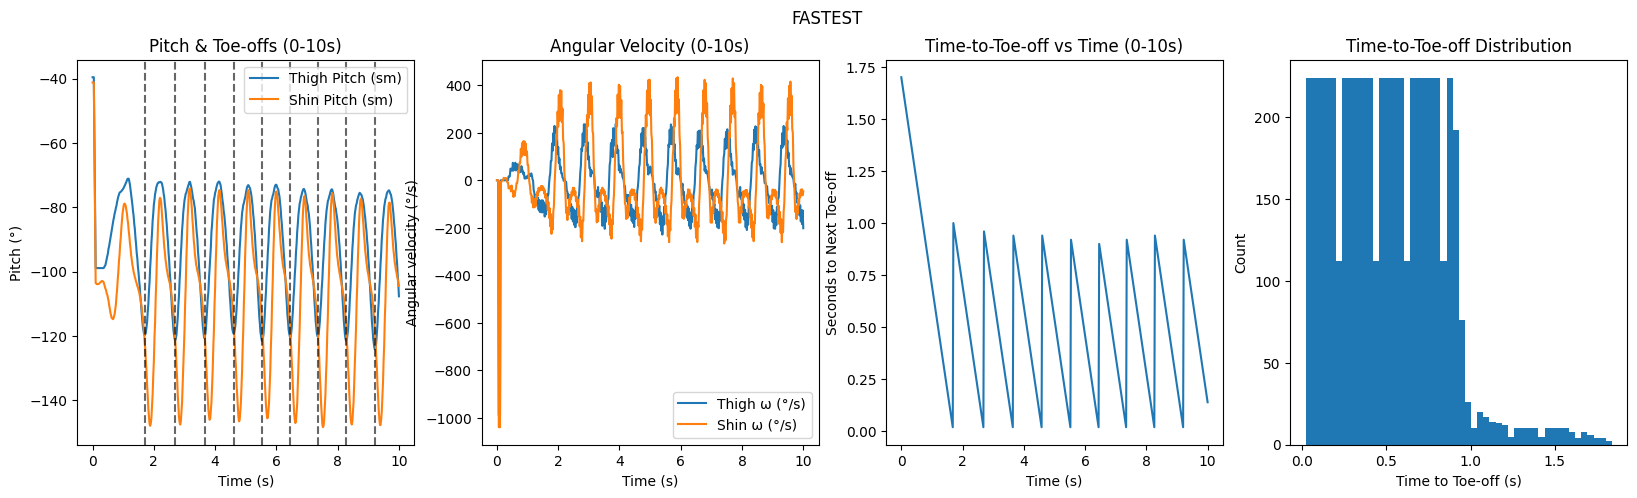

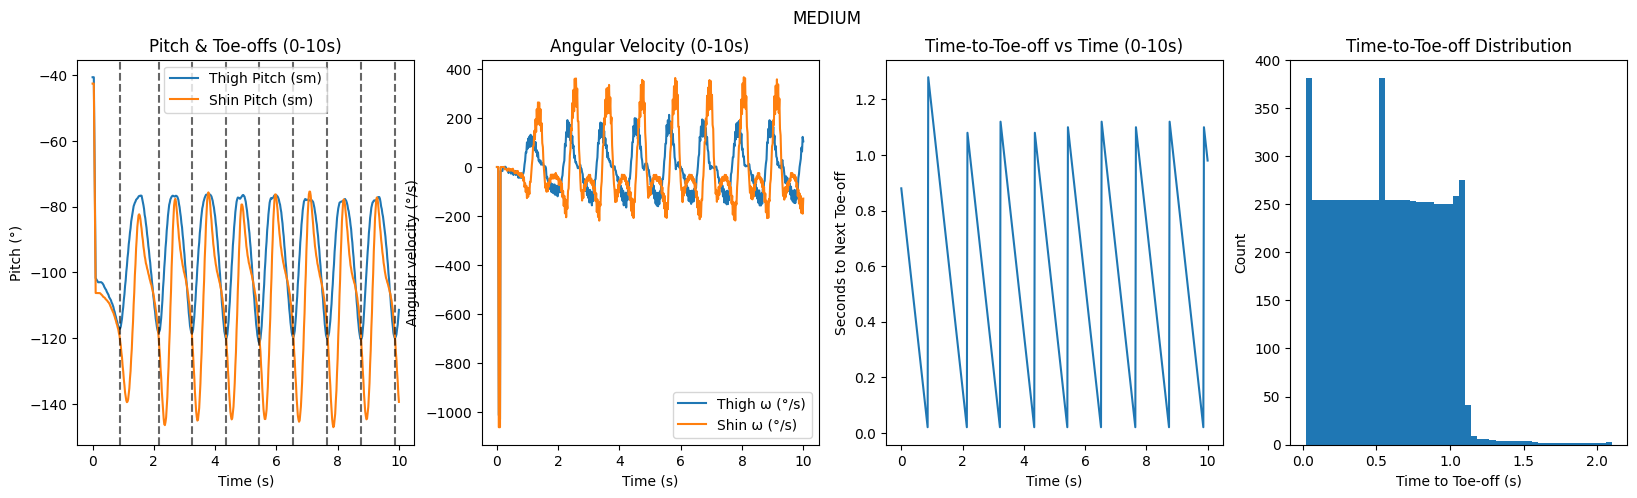

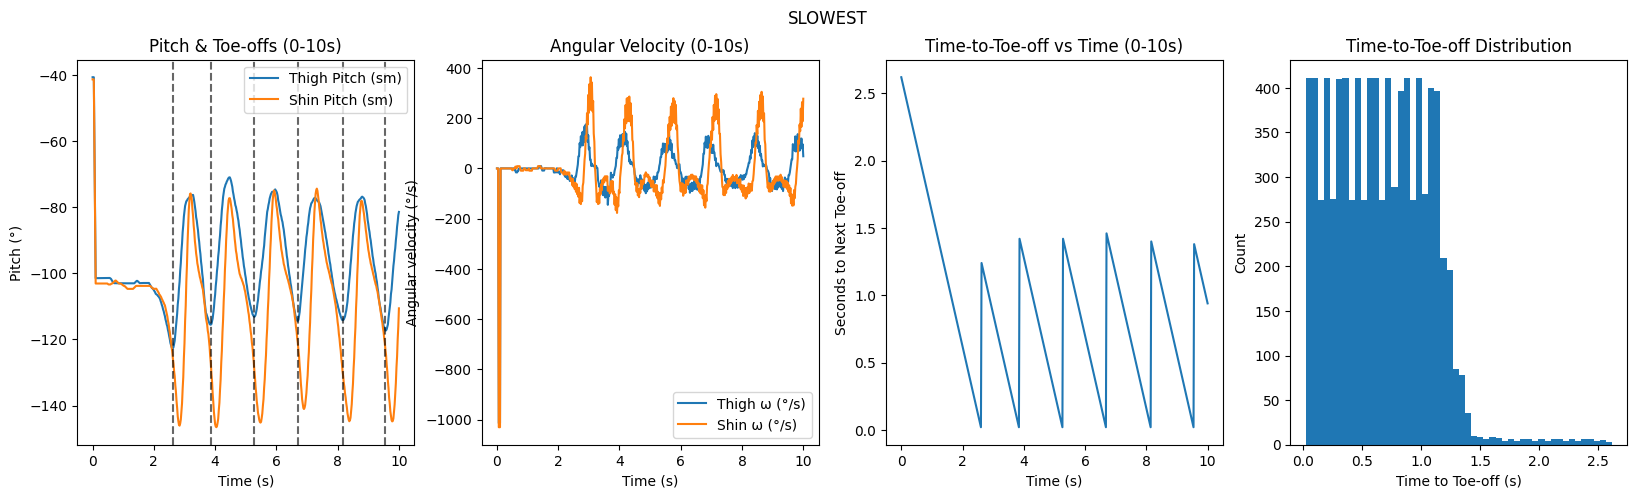

In [9]:
GRU_datasets   = {}
GRU_histories  = {}
GRU_metrics    = {}

X_all_temp = []
y_all_temp = []

for name, path in DATA_FILES.items():
    df    = load_imu_data(path)
    df2   = detect_and_plot_toeoffs(df, title_prefix=name.capitalize())
    X, y  = make_dataset(df2)

    X_all_temp.append(X)
    y_all_temp.append(y)

X_all = np.concatenate([X_all_temp[i] for i in range(len(X_all_temp))], axis=0)
y_all = np.concatenate([y_all_temp[i] for i in range(len(y_all_temp))], axis=0)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2)
y_train_all = y_train_all.reshape(y_train_all.shape[0], -1)
y_test_all = y_test_all.reshape(y_test_all.shape[0], -1)

input_shape = (WINDOW_SZ, X_train_all.shape[2])

In [13]:
loss = 'mse'
metrics = ['mae']
optimizer = Adam(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping('val_mae', patience=10, restore_best_weights=True, verbose=0)

combined_model   = GRU_make_model(input_shape, loss, metrics, optimizer)
combined_history = combined_model.fit(X_train_all, y_train_all,
                                      validation_data=(X_test_all, y_test_all),
                                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])
loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
print(f"Combined val MAE = {mae_c:.3f} for GRU")

GRU_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
GRU_histories["combined"]  = combined_history
GRU_metrics["combined"]    = mae_c

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 64s 215ms/step - loss: 0.0876 - mae: 0.2098 - val_loss: 0.0457 - val_mae: 0.1355
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 79s 204ms/step - loss: 0.0421 - mae: 0.1326 - val_loss: 0.0376 - val_mae: 0.1149
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 85s 216ms/step - loss: 0.0311 - mae: 0.1109 - val_loss: 0.0296 - val_mae: 0.1018
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - loss: 0.0276 - mae: 0.1000 - val_loss: 0.0262 - val_mae: 0.0956
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 84s 227ms/step - loss: 0.0231 - mae: 0.0901 - val_loss: 0.0244 - val_mae: 0.0853
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 77s 209ms/step - loss: 0.0200 - mae: 0.0809 - val_loss: 0.0220 - val_mae: 0.0819
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - loss: 0.0189 - mae: 0.0757 - val_loss: 0.0212 - val_mae: 0.0748
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - loss: 0.0169 - mae: 0.0708 - val_loss: 0.0206 - val_mae: 0.0725
Epoch 9/100
262/262 ━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


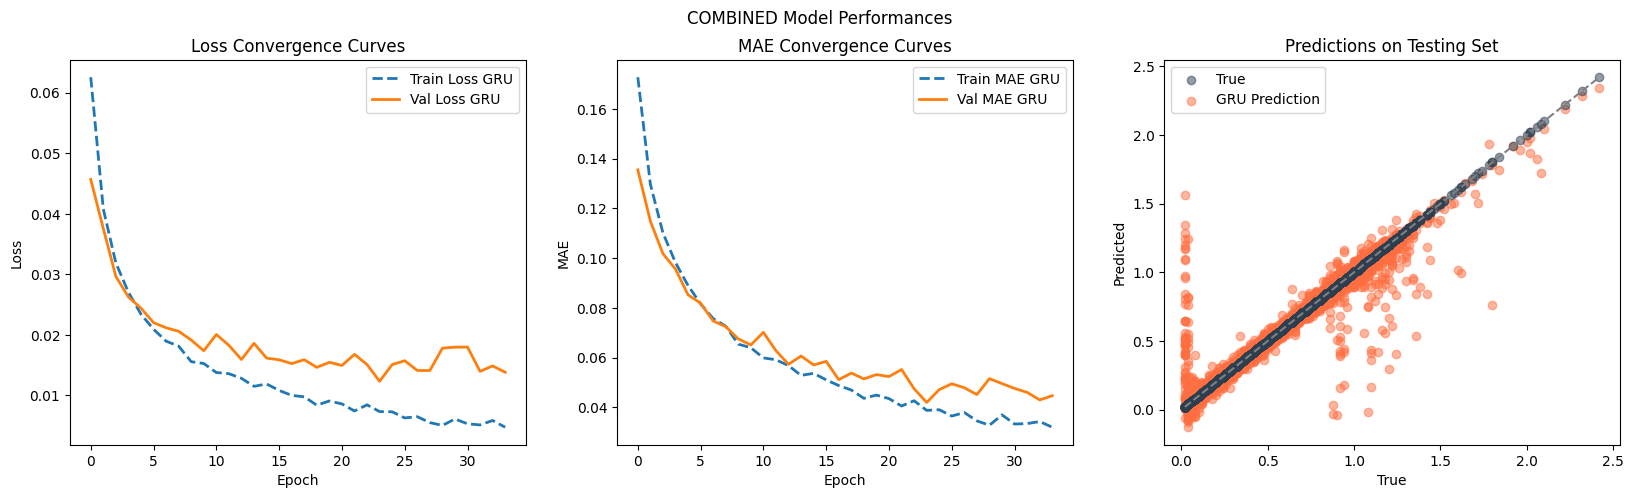

In [16]:
for name in list(GRU_histories.keys()):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"{name.upper()} Model Performances")

    X_test, y_test, model = GRU_datasets[name][2], GRU_datasets[name][3], GRU_datasets[name][4]
    history_gru = GRU_histories[name]
    y_pred_gru = model.predict(X_test).flatten()

    ax[0].plot(history_gru.history['loss'], '--', lw = 2, label='Train Loss GRU')
    ax[0].plot(history_gru.history['val_loss'], lw = 2, label='Val Loss GRU')
    ax[0].set_title("Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history_gru.history['mae'], '--', lw = 2, label='Train MAE GRU')
    ax[1].plot(history_gru.history['val_mae'], lw = 2, label='Val MAE GRU')
    ax[1].set_title(f"MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()

    ax[2].scatter(y_test, y_test, alpha=0.5, color='#2C3E50', label='True', zorder=2)
    ax[2].scatter(y_test, y_pred_gru, alpha=0.5, color='#FF6E40', label='GRU Prediction', zorder=1)
    ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
    ax[2].set_title(f"Predictions on Testing Set")
    ax[2].set_xlabel("True")
    ax[2].set_ylabel("Predicted")
    ax[2].legend()

    np.savez(f"GRU_{name}_history_final.npz", history=np.array([{'history': history_gru.history, 'pred': (y_test, y_pred_gru)}]))

    plt.show()

In [18]:
print(f"Validation MAE for this model is {mae_c} and the Loss is {loss_c}")

Validation MAE for this model is 0.0420050173997879 and the Loss is 0.012325352057814598


In [17]:
for name in list(GRU_datasets.keys()):

  fn = f"GRU_{name}_final.keras"
  model = GRU_datasets[name][-1]
  model.save(fn)
  print(f"Saved {name} to {fn}")

Saved combined to GRU_combined_final.keras
